# TP IoT - Géolocalisation - MS BGD 2016-2017

Groupe : 
* Sami Bargaoui
* Léonard Binet
* Stéphane Trublereau

## Initialisation

In [5]:
# Import des packages
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from geopy.distance import vincenty

In [6]:
# Import des modèles
# premier modèle
from sklearn import linear_model
# modèle knn regressor
from sklearn.neighbors import KNeighborsRegressor
# modèle SVM
from sklearn.svm import SVR
# modèles ensemblistes
from sklearn import ensemble
from sklearn import cross_validation

## Chargement des données

In [7]:
# load train data
df_mess_train = pd.read_csv('mess_train_list.csv') # train set
# load test data
df_mess_test = pd.read_csv('mess_test_list.csv') # test set
pos_train = pd.read_csv('pos_train_list.csv') # position associated to train set

In [8]:
# objid : ident du message reçu
# bsid  : ident base de reception
# did : device de l'emetteur
# rssi : pussance du signal
# time_ux : time de reception du message
# bs_lat et bs_lng : position de la base de reception
df_mess_train.head()
# df_mess_test.head()

,objid,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng
0,573bf1d9864fce1a9af8c5c9,2841,473335.0,0.5,-121.5,1.463546e+12,39.617794,-104.954917
1,573bf1d9864fce1a9af8c5c9,3526,473335.0,2.0,-125.0,1.463546e+12,39.677251,-104.952721
2,573bf3533e952e19126b256a,2605,473335.0,1.0,-134.0,1.463547e+12,39.612745,-105.008827
3,573c0cd0f0fe6e735a699b93,2610,473953.0,2.0,-132.0,1.463553e+12,39.797969,-105.073460
4,573c0cd0f0fe6e735a699b93,3574,473953.0,1.0,-120.0,1.463553e+12,39.723151,-104.956216


In [9]:
df_mess_train.describe()

,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng
count,39250.000000,3.925000e+04,39250.000000,39250.000000,3.925000e+04,39250.000000,39250.000000
mean,4533.774752,4.835932e+05,1.043541,-125.863580,1.473368e+12,42.554998,-100.969685
std,2570.495638,9.893140e+04,0.563540,9.226500,5.506910e+09,7.722787,11.522732
min,879.000000,4.732880e+05,0.000000,-155.000000,1.463546e+12,36.053394,-107.463146
25%,2790.000000,4.761230e+05,1.000000,-132.500000,1.468410e+12,39.747448,-105.074287
50%,3559.000000,4.763150e+05,1.000000,-127.333333,1.473444e+12,39.793585,-105.043685
75%,7456.000000,4.766090e+05,1.500000,-121.000000,1.479118e+12,39.838740,-104.998429
max,11951.000000,1.747448e+06,2.000000,-64.000000,1.481143e+12,64.300000,-68.500000


## Map des Bsid

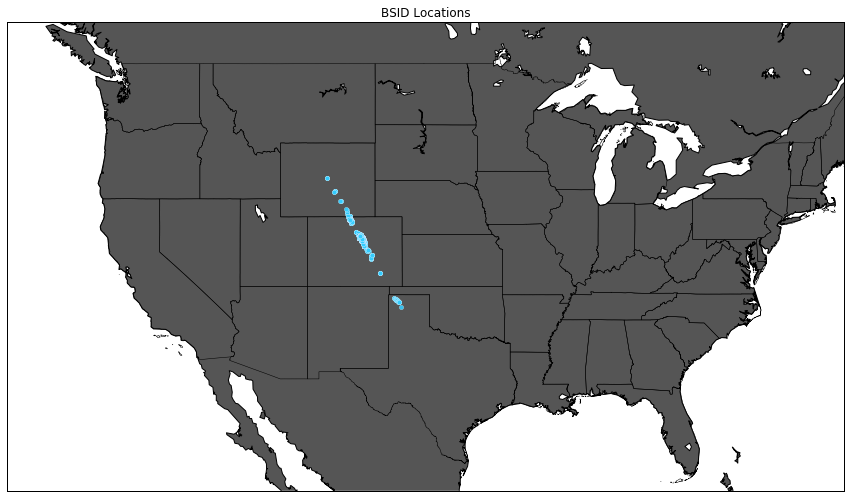

In [11]:
import matplotlib.pyplot as plt
import matplotlib.cm
%matplotlib inline
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.colors import Normalize
fig, ax = plt.subplots(figsize=(15,20))
m = Basemap(resolution='l', # c, l, i, h, f or None
            projection='merc',
            lat_0=37.839763, lon_0=-94.708295,
            llcrnrlon=-131.3, llcrnrlat= 24, urcrnrlon=-69.3, urcrnrlat=51)
m.drawmapboundary(fill_color='#ffffff')
m.fillcontinents(color='#555555',lake_color='#ffffff')
m.drawcoastlines()
plt.title("BSID Locations")
m.readshapefile('map','areas')
lon = pos_train['lng']
lat = pos_train['lat']
for i in range(0, np.shape(lat)[0]):
    x,y = m(lon[i], lat[i])
    m.scatter(x, y, marker='o', lw=.25,
    facecolor='#33ccff', edgecolor='w',
    alpha=0.9, antialiased=True,
    label='Blue Plaque Locations', zorder=3)
m

## Pour construire note matrice de features, on a choisi de ne garder que les messages reçus par au moins 3 balises, ceci a amélioré considérablement nos résultats de régression.

In [12]:
# identification des messages détectés par plus de 3 bsid
chart= df_mess_train.groupby("objid").bsid.count()
message_ids_to_keep = chart[chart>=3].index.values
len(message_ids_to_keep)

3786

In [13]:
# elimination des messages ayant été recus par moins de 3 bsid dans la df de train
df_mess_train = df_mess_train[df_mess_train.objid.isin(message_ids_to_keep)]
df_mess_train.objid.count()

36015

In [14]:
# pos_train
pos_train.describe()

,lat,lng
count,39250.000000,39250.000000
mean,39.783333,-105.056343
std,0.206262,0.162954
min,35.770683,-107.630679
25%,39.708599,-105.060463
50%,39.776882,-105.039440
75%,39.805279,-105.018730
max,43.140387,-102.094289


In [15]:
# elimination de message ayant été recu par moins de 3 bsid dans la df de test
pos_train = pos_train[pos_train.index.isin(df_mess_train.index.values)]
pos_train.describe()

,lat,lng
count,36015.000000,36015.000000
mean,39.783365,-105.056175
std,0.164657,0.133566
min,36.171342,-107.050011
25%,39.710330,-105.060223
50%,39.777468,-105.039717
75%,39.805195,-105.018811
max,42.452279,-102.492562


In [16]:
pos_train.head()

,lat,lng
3,39.730417,-104.968940
4,39.730417,-104.968940
5,39.730417,-104.968940
6,39.693102,-105.006995
7,39.693102,-105.006995


In [17]:
pos_train.describe()

,lat,lng
count,36015.000000,36015.000000
mean,39.783365,-105.056175
std,0.164657,0.133566
min,36.171342,-107.050011
25%,39.710330,-105.060223
50%,39.777468,-105.039717
75%,39.805195,-105.018811
max,42.452279,-102.492562


In [18]:
# determine all Base stations that received at least 1 message 
#(sur les jeux de train et de test)
listOfBs = np.union1d(np.unique(df_mess_train['bsid']), np.unique(df_mess_test['bsid'])) 

## Construction de la nouvelle matrice de features :

## Pour construire notre nouvelle matrice de features, on tient en compte de la puissance du signal pour chaque message et relativement à chaque balise.

In [19]:
# Feature Matrix construction 

def feat_mat_const(df_mess_train, listOfBs):
    my_df = df_mess_train[['objid','bsid','nseq']]
    my_df['value'] = df_mess_train[['rssi']]
    df_feat = my_df.pivot(index='objid', columns='bsid', values='value').fillna(-155)
    bsid_set = set(listOfBs)
    print(len(bsid_set))
    exist = set(df_feat.columns)
    print(len(exist))
    missing = bsid_set - exist
    print(missing)
    # colonne manquant dans le modele produit dans le jeu d'entrainement
    for col in missing: 
        df_feat[col]= -155
    df_feat.shape
    print(df_feat.shape)
    return df_feat

In [21]:
df_feat = feat_mat_const(df_mess_train, listOfBs)
# Ici, on tient compte des balises qui n'ont reçu aucun message (8 balises)

251
241
set([8392, 1131, 3629, 9936, 8168, 3828, 9941, 9783, 3034, 9949])
(3786, 251)


C:\Users\Rim\Anaconda2\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [22]:
# ground truth construction
# récuperation de la moyenne latitude et de la moyenne longitude

def ground_truth_const(df_mess_train, pos_train):
    df_mess_pos = df_mess_train.copy()
    df_mess_pos[['lat', 'lng']] = pos_train
    ground_truth_lat = np.array(df_mess_pos.groupby(['objid']).mean()['lat'])
    ground_truth_lng = np.array(df_mess_pos.groupby(['objid']).mean()['lng'])
    return ground_truth_lat, ground_truth_lng

In [23]:
ground_truth_lat, ground_truth_lng = ground_truth_const(df_mess_train, pos_train)
print(ground_truth_lat.shape)
print(ground_truth_lng.shape)

(3786L,)
(3786L,)


## 1. Algorithme des plus proches voisins KNN :

In [24]:
def regressor_and_predict(df_feat, ground_truth_lat, ground_truth_lng, df_test):
    
    # train regressor and make prediction in the train set
    # Input: df_feat: feature matrix used to train regressor
    #        ground_truth_lat: df_feat associated latitude
    #        ground_truth_lng: df_feat associated longitude
    #        df_test: data frame used for prediction
    # Output: y_pred_lat, y_pred_lng

    X_train = np.array(df_feat);
    reg = KNeighborsRegressor(n_neighbors=7, weights='distance',p=1 )
    
    reg.fit(X_train, ground_truth_lat);
    y_pred_lat = reg.predict(df_test) 

    reg.fit(X_train, ground_truth_lng);
    y_pred_lng = reg.predict(df_test) 

    return y_pred_lat, y_pred_lng, reg



In [25]:
# Make regressor and prediction using the train set

In [26]:
y_pred_lat, y_pred_lng, reg = regressor_and_predict(df_feat, ground_truth_lat, ground_truth_lng, df_feat)

In [27]:
# Cross validation

In [28]:
from sklearn.model_selection import cross_val_predict
X_train = np.array(df_feat)
#Knn
y_pred_lng = cross_val_predict(reg, X_train, ground_truth_lng, cv=10)
y_pred_lat = cross_val_predict(reg, X_train, ground_truth_lat, cv=10)

In [29]:
# Evaluate result

In [30]:
def vincenty_vec(vec_coord):
    vin_vec_dist = np.zeros(vec_coord.shape[0])
    if vec_coord.shape[1] !=  4:
        print('ERROR: Bad number of columns (shall be = 4)')
    else:
        vin_vec_dist = [vincenty(vec_coord[m,0:2],vec_coord[m,2:]).meters for m in range(vec_coord.shape[0])]
    return vin_vec_dist

In [31]:
# evaluate distance error for each predicted point
def Eval_geoloc(y_train_lat , y_train_lng, y_pred_lat, y_pred_lng):
    vec_coord = np.array([y_train_lat , y_train_lng, y_pred_lat, y_pred_lng])
    err_vec = vincenty_vec(np.transpose(vec_coord))
    
    return err_vec

In [32]:
err_vec = Eval_geoloc(ground_truth_lat , ground_truth_lng, y_pred_lat, y_pred_lng)

In [33]:
# Plot error distribution

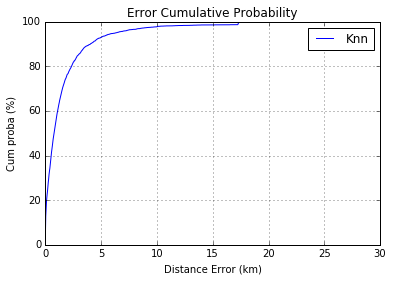

In [34]:
values, base = np.histogram(err_vec, bins=50000)
cumulative = np.cumsum(values) 
plt.figure();
plt.plot(base[:-1]/1000, cumulative / np.float(np.sum(values))  * 100.0, c='blue')
plt.grid(); plt.xlabel('Distance Error (km)'); plt.ylabel('Cum proba (%)'); plt.axis([0, 30, 0, 100]); 
plt.title('Error Cumulative Probability'); plt.legend( ["Knn"])

In [35]:
# Error criterion

print "L'erreur est", np.percentile(err_vec, 80)/1000, "Km avec les Knn"

L'erreur est 2.35452190593 Km avec les Knn


## 2. ExtraTreesRegressor :

In [36]:
def regressor_and_predict(df_feat, ground_truth_lat, ground_truth_lng, df_test):
    
    # train regressor and make prediction in the train set
    # Input: df_feat: feature matrix used to train regressor
    #        ground_truth_lat: df_feat associated latitude
    #        ground_truth_lng: df_feat associated longitude
    #        df_test: data frame used for prediction
    # Output: y_pred_lat, y_pred_lng

    X_train = np.array(df_feat);    
    reg = ensemble.ExtraTreesRegressor(n_estimators=100, 
	max_depth=None, max_features='auto')
    
    reg.fit(X_train, ground_truth_lat);
    y_pred_lat = reg.predict(df_test) 

    reg.fit(X_train, ground_truth_lng);
    y_pred_lng = reg.predict(df_test) 

    return y_pred_lat, y_pred_lng, reg
    

In [37]:
y_pred_lat, y_pred_lng, reg = regressor_and_predict(df_feat, ground_truth_lat, ground_truth_lng, df_feat)

In [38]:
from sklearn.model_selection import cross_val_predict
X_train = np.array(df_feat)
#ETR
y_pred_lng = cross_val_predict(reg, X_train, ground_truth_lng, cv=10)
y_pred_lat = cross_val_predict(reg, X_train, ground_truth_lat, cv=10)

In [39]:
err_vec = Eval_geoloc(ground_truth_lat , ground_truth_lng, y_pred_lat, y_pred_lng)

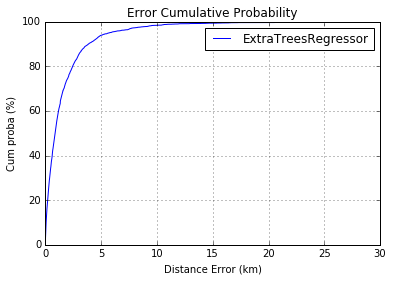

In [40]:
values, base = np.histogram(err_vec, bins=50000)
cumulative = np.cumsum(values) 
plt.figure();
plt.plot(base[:-1]/1000, cumulative / np.float(np.sum(values))  * 100.0, c='blue')
plt.grid(); plt.xlabel('Distance Error (km)'); plt.ylabel('Cum proba (%)'); plt.axis([0, 30, 0, 100]); 
plt.title('Error Cumulative Probability'); plt.legend( ["ExtraTreesRegressor"])

In [41]:
# Error criterion

print "L'erreur est", np.percentile(err_vec, 80)/1000, "Km avec l'ExtraTreesRegressor"

L'erreur est 2.45688934349 Km avec l'ExtraTreesRegressor


In [42]:
# Export en CSV

In [43]:
test_res = pd.DataFrame(np.array([y_pred_lat, y_pred_lng]).T, columns = ['lat', 'lng'])
test_res.to_csv('pred_pos_test_list.csv', index=False)
test_res.head()

,lat,lng
0,39.731859,-104.972331
1,39.691615,-105.006085
2,39.751511,-105.029106
3,39.708380,-104.999204
4,39.744885,-105.048996


# Conclusions et Synthèse

*  On a retenu les méthodes Knn et ExtraTrees qui fournissaient les meilleurs résultats.
*  La construction de la nouvelle matrice de features RSSI améliore nos scores par rapport à la première matrice. 
*  Eliminer les messages qui sont reçus par mois de 3 balises nous as permis d'améliorer notre prédiction.
*  On a essayé de tenir en compte de la feature "nseq" en l'intégrant dans la matrice de features ou en créeant une nouvelle variable à partir de cette dernière mais ça n'a pas impacté nos resultats donc on s'est restreint à la matrice des RSSI.